In [31]:
"""
Since the output of at any CVT points for HDPE is not available,
we will not carry out evaluating metrics on the generated virtual samples,
as the way that have done for magical_sinus benchmarking dataset. Instead,
we indirectly confirm the quality of the generated samples by showing the
ability of our RegCGAN on capturing P(y|x).
"""


import importlib

import dataset, metrics, plotting, config, network
from models import reg_cgan_model
import numpy as np
import random

importlib.reload(network)
importlib.reload(dataset)
importlib.reload(metrics)
importlib.reload(plotting)
importlib.reload(config)
importlib.reload(reg_cgan_model)

<module 'models.reg_cgan_model' from '/Users/zhongsheng/Documents/GitWorkspace/RegCGAN/models/reg_cgan_model.py'>

In [32]:
import os

dataset_config = config.DatasetConfig(scenario="hdpeuce")

assert(dataset_config.scenario == "magical_sinus"
      or dataset_config.scenario == "hdpeuce")
fig_dir = f"../figures/{dataset_config.scenario}"

try:
    os.mkdir(fig_dir)
    print(f"Directory {fig_dir} created ")
except FileExistsError:
    print(f"Directory {fig_dir} already exists replacing files in this notebook")

Directory ../figures/hdpeuce already exists replacing files in this notebook


In [33]:
exp_config = config.Config(
    model=config.ModelConfig(activation="elu", lr_gen=0.0001, lr_disc=0.0001,
                             optim_gen="Adam", optim_disc="Adam", z_input_size=5),
    training=config.TrainingConfig(n_epochs=10000, batch_size=100, n_sampling=200),
    dataset=dataset_config,
    run=config.RunConfig(save_fig=1)
)

In [34]:
# Set random seed
np.random.seed(exp_config.model.random_seed)
random.seed(exp_config.model.random_seed)

from tensorflow import set_random_seed
set_random_seed(exp_config.model.random_seed)

In [35]:
X_train, y_train, X_valid, y_valid = dataset.get_dataset(scenario=exp_config.dataset.scenario,
                                                                         seed=exp_config.model.random_seed)

In [36]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_valid_scaled = X_scaler.fit_transform(X_valid)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_valid_scaled = y_scaler.fit_transform(y_valid.reshape(-1, 1))

## Gaussian Process

In [37]:
import GPy

variance = 0.1
length = 1

kernel = GPy.kern.RBF(input_dim=15, variance=variance, lengthscale=length)
gpr = GPy.models.GPRegression(X_train_scaled, y_train_scaled, kernel)

run_hyperopt_search = True
if run_hyperopt_search:
    gpr.optimize(messages=True)

## Construct CGAN model

In [38]:
import time

start_time = time.time()
regcgan = reg_cgan_model.RegCGAN(exp_config)
d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true = regcgan.train(X_train, y_train,
                                                                              epochs=exp_config.training.n_epochs,
                                                                              batch_size=exp_config.training.batch_size,
                                                                              verbose=True)
time_cost = time.time() - start_time

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Generator_input_x (InputLayer)  (None, 15)           0                                            
__________________________________________________________________________________________________
Generator_input_z (InputLayer)  (None, 5)            0                                            
__________________________________________________________________________________________________
dense_36 (Dense)                (None, 60)           960         Generator_input_x[0][0]          
__________________________________________________________________________________________________
dense_37 (Dense)                (None, 60)           360         Generator_input_z[0][0]          
__________________________________________________________________________________________________
concatenat

 /Users/zhongsheng/anaconda2/envs/Reg-CGAN/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


In [39]:
print(time_cost)

932.2393529415131


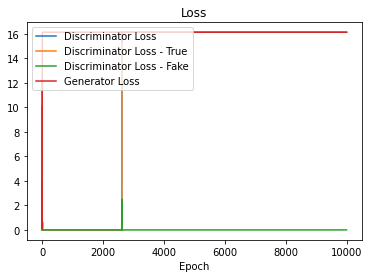

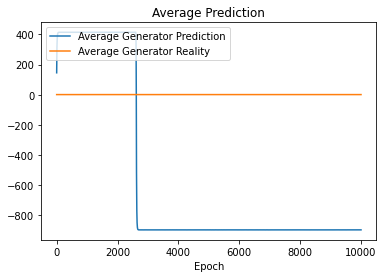

In [40]:
plotting.plot_training_curve(d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true, fig_dir, exp_config.run.save_fig)

## Generate pairs of virtual samples

In [41]:
from os.path import basename
X_cvt = np.load(f"{fig_dir}/{basename(fig_dir)}_cvt_samples.npy")
X_cvt_scaled = X_scaler.transform(X_cvt[:, :-1])

In [42]:
ypred_recgan_cvt = regcgan.predict(X_cvt_scaled)
ypred_gp_cvt, cov_cvt = gpr.predict(X_cvt_scaled)

In [43]:
ypred_recgan_cvt = y_scaler.inverse_transform(ypred_recgan_cvt)
ypred_gp_cvt = y_scaler.inverse_transform(ypred_gp_cvt)

In [44]:
X_cvt_paird = np.c_[X_cvt, ypred_recgan_cvt]

In [45]:
from os.path import basename
np.save(f"{fig_dir}/{basename(fig_dir)}_CVT_samples_paired.npy", X_cvt_paird)
